In [1]:
import pickle 
import yaml
import pandas as pd
from PrepareData import prepare_data


import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import seaborn as sns
from architecture import CLIP
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32


In [2]:
from train_utils import load_model

In [3]:
val_ids = pickle.load(open('./checkpoints/FULL_COMBINED/val_ids.pickle', 'rb'))

In [4]:
def make_deterministic(random_seed = 0):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

In [5]:
make_deterministic(0)

In [6]:
config = yaml.safe_load(open('./checkpoints/FULL_COMBINED/config.yaml', 'r'))


In [7]:
logs = pickle.load(open('./checkpoints/FULL_COMBINED/logs.pickle', 'rb'))
for key in logs:
    if "best" in key:
        print(key, logs[key])

best_epoch 618
best_clip_epoch 684
best_recon_epoch 195
best_total_loss 0.05993457242846489
best_clip_loss 0.012829888865817339
best_recon_loss 0.039655369743704795


In [8]:
model = load_model(config['train']['checkpoint_dir'], type="best_latest")
model.eval()
dataloaders, max_charge, num_species = prepare_data(config)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [9]:
all_ids = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['val'])):    
        data = {k: v.to(device) for k, v in data.items()}
        mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
        all_ids.append(ids.detach().cpu())
all_ids = torch.cat(all_ids, 0)

50it [00:58,  1.18s/it]


In [10]:
count = 0
for id in val_ids:
    if id in all_ids:
        count += 1 
count

20000

In [11]:
from train_utils import decoder_performance
from train_utils import top_scores, decoder_performance, distance_distribution

def clip_performance(config, model, dataloaders, epoch):
    # model.to(device)
    model.eval()
    max_charge = config['data']['max_charge']
    num_species = config['data']['num_species']

    molembeds = []
    specembeds = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['val'])):    
            data = {k: v.to(device) for k, v in data.items()}
            mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
            molembeds.append(mol_latents.detach().cpu())
            specembeds.append(spec_latents.detach().cpu())
        del mol_latents, spec_latents, smile_preds, logit_scale, ids

    test_molembeds = torch.cat(molembeds, 0)
    test_specembeds = torch.cat(specembeds, 0)
    
    molembeds = []
    specembeds = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['train'])):    
            data = {k: v.to(device) for k, v in data.items()}
            mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
            molembeds.append(mol_latents.detach().cpu())
                # specembeds.append(spec_latents.detach().cpu())
        del mol_latents, spec_latents, smile_preds, logit_scale, ids
    
    train_molembeds = torch.cat(molembeds, 0)
    # train_specembeds = torch.cat(specembeds, 0)
    
    # all_molembeds = torch.cat(( test_molembeds, train_molembeds), axis = 0)
    # # del train_molembeds
    
    # tops, scores = top_scores(test_specembeds, all_molembeds)
    # del all_molembeds
    
    # for k, acc in zip(tops, scores):
    #     # print("Full Top {} Spec".format(k), acc)
    #     print({"Full Top {} Spec".format(k): acc})
        

    # tops, scores = top_scores(test_specembeds, test_molembeds )
    # for k, acc in zip(tops, scores):
    #     # print("Test Top {} Spec".format(k), acc)
    #     print({"Test Top {} Spec".format(k): acc})

    # decoder_performance(config, model, dataloaders, epoch)
    plt.clf()
    # distance_distribution(test_molembeds, test_specembeds)
    return test_molembeds, train_molembeds, test_specembeds

In [12]:
from train_utils import top_scores, decoder_performance, distance_distribution
test_molembeds, train_molembeds, test_specembeds = clip_performance(config,model,dataloaders, -1)

50it [00:58,  1.17s/it]
250it [05:03,  1.21s/it]


In [13]:
test_smiles = []
test_irs = []
for i, data in enumerate(dataloaders['val']):
    test_smiles.append(data['smiles'].detach().cpu())
    test_irs.append(data['IR'].detach().cpu())
test_smiles = torch.cat(test_smiles, 0)
test_irs = torch.cat(test_irs, 0)

train_smiles = []
train_irs = []
for i, data in enumerate(dataloaders['train']):
    train_smiles.append(data['smiles'].detach().cpu())
    train_irs.append(data['IR'].detach().cpu())
train_smiles = torch.cat(train_smiles, 0)
train_irs = torch.cat(train_irs, 0)

In [14]:
all_molembeds = torch.cat(( test_molembeds, train_molembeds), axis = 0)
all_smiles = torch.cat((test_smiles, train_smiles), axis = 0)
all_irs = torch.cat((test_irs, train_irs), axis= 0 )

In [15]:
hits = []
for i in range(test_specembeds.shape[0]):
    sims = all_molembeds @ test_specembeds[i].t()
    max_sims, ids = torch.topk(sims, 3)
    hits.append(ids)

In [16]:
def get_mol(one_hot):
    smiles = ""
    chars = model.module.vocab.from_seq(one_hot)
    for char in chars:
        if char != "<pad>" and char != "<eos>" and char != "<sos>" and char != "<unk>":
            smiles += char
    return Chem.MolFromSmiles( Chem.CanonSmiles(smiles))

def get_smile(one_hot):
    smiles = ""
    chars = model.module.vocab.from_seq(one_hot)
    for char in chars:
        if char != "<pad>" and char != "<eos>" and char != "<sos>" and char != "<unk>":
            smiles += char
    return  Chem.CanonSmiles(smiles)

In [17]:
imgs = []
ids = []
for i, t in enumerate(hits):
    if t[0] != i and t[1] == i:
        og_mol = get_mol(all_smiles[i])
        first_mol = get_mol(all_smiles[t[0]])
        second_mol = get_mol(all_smiles[t[1]])
        third_mol = get_mol(all_smiles[t[2]])
        
        mols = np.array([og_mol, first_mol, second_mol, third_mol])
        imgs.append(Draw.MolsToGridImage(mols, molsPerRow=4, returnPNG=False))
        ids.append([i,t[0], t[1], t[2]])
        
    if t[0] != i and t[2] == i:
        og_mol = get_mol(all_smiles[i])
        first_mol = get_mol(all_smiles[t[0]])
        second_mol = get_mol(all_smiles[t[1]])
        third_mol = get_mol(all_smiles[t[2]])
        
        mols = np.array([og_mol, first_mol, second_mol, third_mol])
        imgs.append(Draw.MolsToGridImage(mols, molsPerRow=4, returnPNG=False))
        ids.append([i,t[0], t[1], t[2]])


In [24]:
from rdkit import DataStructs
# from rdkit import AllChem
from rdkit.Chem import rdMolDescriptors,AllChem
def molecule_similarity(mol1, mol2, radius=2, nBits=1024,
                                      useChirality=False):
    try:
        mol1 = Chem.MolFromSmiles(mol1)
        mol2 = Chem.MolFromSmiles(mol2)
        fp1 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol1, radius=radius,
                                                            nBits=nBits,
                                                            useChirality=useChirality)
        fp2 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol2,
                                                                radius=radius,
                                                            nBits=nBits,
                                                            useChirality=useChirality)
        # fpgen = AllChem.GetRDKitFPGenerator()
        # fp1 = fpgen.GetFingerprint(mol1)
        # fp2 = fpgen.GetFingerprint(mol2)
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    except:
        return 0

def spectral_sim(ir1, ir2):
    ir1 = ir1.numpy()
    ir2 = ir2.numpy()
    ir1 = ir1 / ir1.sum()
    ir2 = ir2 / ir2.sum()
    d = ir1*np.log(ir1/ir2)+ir2*np.log(ir2/ir1)
    return 1/(1+d.sum()) 

sims = []
molsims = []
for anchor in range(len(ids)):
    sim = spectral_sim(all_irs[ids[anchor][0]], all_irs[ids[anchor][1]])
    sims.append(sim)
    sim = molecule_similarity(get_smile(all_smiles[ids[anchor][0]]), get_smile(all_smiles[ids[anchor][1]]) )
    molsims.append(sim)
    

def topk_by_sort(input, k, axis=None, ascending=False):
    if not ascending:
        input *= -1
    ind = np.argsort(input, axis=axis)
    ind = np.take(ind, np.arange(k), axis=axis)
    if not ascending:
        input *= -1
    val = np.take_along_axis(input, ind, axis=axis) 
    return ind, val

inds, vals = topk_by_sort(np.array(sims),20)
print(inds)

[3123 1109 3006 2564 1528 1734  490 1931 3025 1303 2593  396 1099 1020
   97  906  616 2371  668 2807]


In [25]:
vals

array([0.83086704, 0.78668632, 0.78100027, 0.760501  , 0.7585362 ,
       0.75067655, 0.74991243, 0.74969771, 0.7372524 , 0.73450522,
       0.72973717, 0.7206678 , 0.71828361, 0.69421364, 0.69101804,
       0.69042844, 0.68977229, 0.68428185, 0.6827807 , 0.67447233])

In [49]:
anchor = 1931

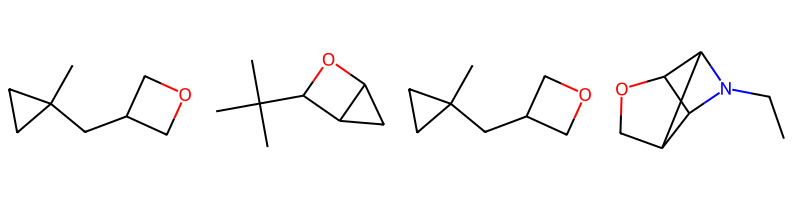

In [50]:
# imgs[anchor].save('images/rdkit_rank3_misalign.png')
imgs[anchor]

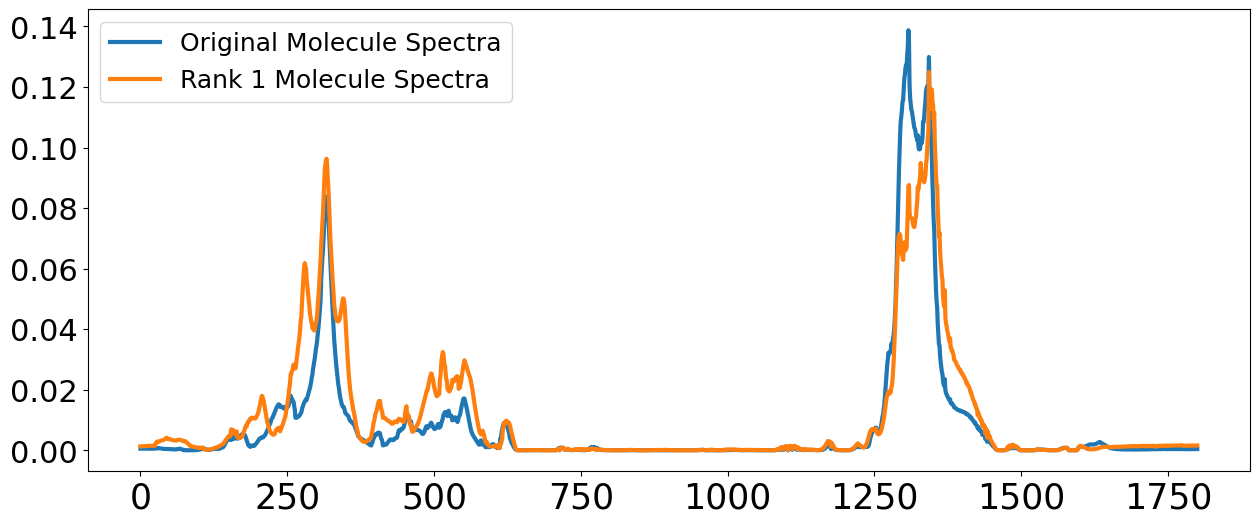

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 6))
plt.plot(all_irs[ids[anchor][0]], label="Original Molecule Spectra", linewidth=3)
plt.plot(all_irs[ids[anchor][1]], label= "Rank 1 Molecule Spectra", linewidth=3)
plt.xticks(fontsize=25)
plt.yticks(fontsize=22)
plt.legend(fontsize="18")
plt.savefig("images/misaligned_rank3_sim.png", dpi=300)

In [52]:
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors
def molecule_similarity(mol1, mol2, radius=2, nBits=1024,
                                      useChirality=False):
    fp1 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol1, radius=radius,
                                                        nBits=nBits,
                                                        useChirality=useChirality)
    fp2 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol2,
                                                            radius=radius,
                                                        nBits=nBits,
                                                        useChirality=useChirality)
    return DataStructs.TanimotoSimilarity(fp1, fp2)
    

In [53]:
def top_k_molsims(topk):
    hits = []
    for i in tqdm(range(test_specembeds.shape[0])):
        sims = all_molembeds @ test_specembeds[i].t()
        max_sims, ids = torch.topk(sims, topk)
        hits.append(ids)

    molsims = []
    for i, t in enumerate(hits):
        if t[0] != i:
            og_mol = get_mol(all_smiles[i])
            for k in t:
                ranked_mol = get_mol(all_smiles[k])
                molsims.append(molecule_similarity(og_mol, ranked_mol))
    return molsims        


In [54]:
sims = top_k_molsims(1)

100%|██████████| 20000/20000 [01:40<00:00, 199.56it/s]


(array([245.,   0.,  50., 582.,  58.,  50., 575., 282.,  80., 345., 393.,
        156., 182., 291., 203., 137., 140., 120.,  86.,  74.,  63.,  54.,
         56.,  34.,  22.,  24.,  29.,   9.,  18.,   8.,   9.,   8.,   6.,
          5.,   3.,   2.,   5.,   1.,   4.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   2.]),
 array([0.        , 0.00769231, 0.01538462, 0.02307692, 0.03076923,
        0.03846154, 0.04615385, 0.05384615, 0.06153846, 0.06923077,
        0.07692308, 0.08461538, 0.09230769, 0.1       , 0.10769231,
        0.11538462, 0.12307692, 0.13076923, 0.13846154, 0.14615385,
        0.15384615, 0.16153846, 0.16923077, 0.17692308, 0.18461538,
        0.19230769, 0.2       , 0.20769231, 0.21538462, 0.22307692,
        0.23076923, 0.23846154, 0.24615385, 0.25384615, 0.26153846,
        0.26923077, 0.27692308, 0.28461538, 0.29230769, 0.3       ,
        0.30769231, 0.31538462, 0.32307692, 0.33076923, 0.33846154,
        0.34615385, 0.35384615, 0.36153846, 0.

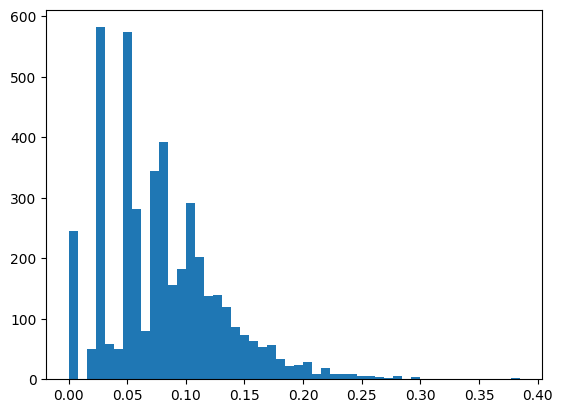

In [56]:
plt.hist(sims, bins=50)

In [57]:
sns.color_palette()[0]


(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [58]:
def distance_distribution(molmat, specmat):
    sns.set(rc={'figure.figsize':(9,6)})
    sns.set_style("white")
    sim_mat = specmat@ molmat.t()
    
    diagonals = torch.diagonal(sim_mat, 0).detach().cpu().clone().numpy()
    sims = np.random.choice(sim_mat.view(-1).cpu().numpy(), len(diagonals))
    # vals = np.concatenate((sims, diagonals), axis=0)
    # pairs = ["Pairs"] * len(diagonals)
    # nonpairs = ["Random Nonpair"] * len(sims)
    # df = pd.DataFrame()
    # df['Similarity'] = vals
    # df['labels'] = nonpairs + pairs
    # plt.clf()
    # plot = sns.histplot(df, x='Similarity', hue='labels', bins=50, element="poly", stat="percent", linewidth=3)
    # sns.move_legend(plot, "upper left")
    # plt.yticks(fontsize=15)
    # plt.xticks(fontsize=15)
    # del sims, diagonals,  vals, df
    # return plot
    
    
    values,indices = torch.topk(sim_mat,k=2,dim=0)
    pair_vals = []
    nonpair_vals = []
    for i in range(specmat.shape[0]):
        if indices[0][i] == i:
           pair_vals.append(values[0][i])
        else:
            nonpair_vals.append(values[0][i]) 
    diagonals = np.array(pair_vals)
    sims = np.array(nonpair_vals)
    
    vals = np.concatenate((sims, diagonals), axis=0)
    pairs = ["Correct Pairs Similarity"] * len(diagonals)
    nonpairs = ["Incorrect Pair Closest Neighbour Similarity"] * len(sims)
    df = pd.DataFrame()
    df['Similarity'] = vals
    df['labels'] = nonpairs + pairs
    plt.clf()
    # plot = sns.histplot(df, x='Similarity', hue='labels', bins=50, element="poly", stat="percent", linewidth=3)
    plot = sns.kdeplot(df, x='Similarity', hue='labels', fill=True, alpha=0.5, linewidth=3, common_norm=True)
    plot.axvline(np.mean(pair_vals), color=sns.color_palette()[1], linestyle="dashed", ymax = 0.9)
    plot.axvline(np.mean(nonpair_vals), color=sns.color_palette()[0], linestyle="dashed", ymax=0.04)
    sns.move_legend(plot, "upper left")
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    del sims, diagonals,  vals, df
    
    # values,indices = torch.topk(sim_mat,k=3,dim=0)
    # firsts = []
    # seconds = []
    # thirds = []
    # for i in range(specmat.shape[0]):
    #     if indices[0][i] == i:
    #        firsts.append(values[0][i].item())
    #         # pass
    #     elif indices[1][i] == i:
    #         seconds.append(values[1][i].item())
    #     else:
    #         thirds.append(values[2][i].item())

    # df = pd.DataFrame()
    # df['Similarity'] = firsts + seconds + thirds 
    # df['labels'] = ['First Closest']*len(firsts) + ['Second Closest']*len(seconds) + ['Third Closest']*len(thirds) 
    # plt.clf()
    # # plot = sns.histplot(df, x='Similarity', hue='labels', bins=50, element="poly", stat="percent", linewidth=3)
    # plot= sns.kdeplot(df, x='Similarity', hue='labels', fill=True, alpha=0.5, linewidth=3, common_norm=False)
    # sns.move_legend(plot, "upper left")
    # plt.yticks(fontsize=15)
    # plt.xticks(fontsize=15)
    # del sims, diagonals,  vals, df
    
    # values,indices = torch.topk(sim_mat,k=3,dim=0)
    # firsts = []
    # seconds = []
    # thirds = []
    # randoms = list(sims)
    # for i in range(specmat.shape[0]):
    #     if indices[0][i] == i:
    #        firsts.append(values[0][i].item())
    #         # pass
    #     elif indices[1][i] == i:
    #         seconds.append(values[1][i].item())
    #     else:
    #         thirds.append(values[2][i].item())

    # df = pd.DataFrame()
    # df['Similarity'] = firsts + seconds + thirds + randoms
    # df['labels'] = ['First Closest']*len(firsts) + ['Second Closest']*len(seconds) + ['Third Closest']*len(thirds) + ['Random']*len(randoms)
    # plt.clf()
    # # plot = sns.histplot(df, x='Similarity', hue='labels', bins=50, element="poly", stat="percent", linewidth=3)
    # plot= sns.kdeplot(df, x='Similarity', hue='labels', fill=True, alpha=0.5, linewidth=3, common_norm=False)
    # sns.move_legend(plot, "upper left")
    # plt.yticks(fontsize=15)
    # plt.xticks(fontsize=15)
    # del sims, diagonals,  df
    
    return plot

<AxesSubplot: xlabel='Similarity', ylabel='Density'>

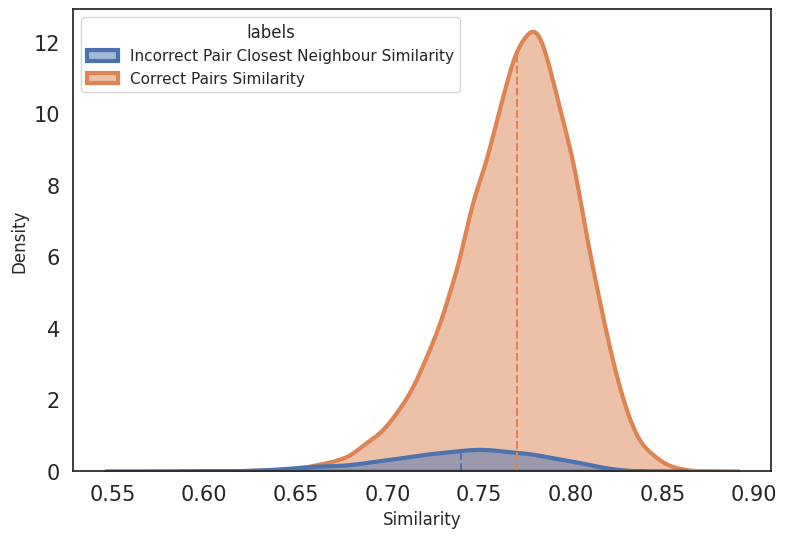

In [71]:
%matplotlib inline
img = distance_distribution(test_molembeds, test_specembeds)
img

In [38]:
# img.get_figure().savefig('Correct top Pairs vs Random Pairs', dpi=300)

In [72]:
img.get_figure().savefig('Correct Pairs vs Incorrect Pairs', dpi=300)